# Train-test of single PINN poisson

In [4]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
from jaxopt import LBFGS

In [5]:
from utils import data_path , fig_path
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

(900, 2)
(120, 2)


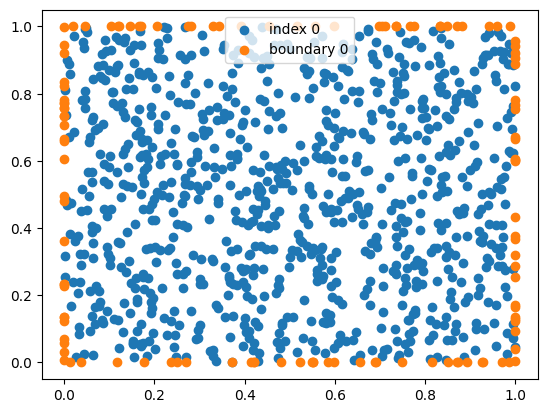

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()
#plt.savefig(fig_path / f"Poisson/single_pinn_decomp.pdf")

In [7]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))

def boundary_loss_factory(index: int, target: float | Array)-> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = xpinn.PINNs[index].v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss


In [8]:
def interior_loss_factory(index: int, rhs: Callable[[Array], Array]) -> LFunc:
            
    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) + rhs(x)

    v_residual = jit(vmap(residual, (None, 0)))#vmap(residual, (None, 0))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

In [9]:
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

In [10]:
p0 = xpinn.PINNs[0]

p0.boundary_loss = boundary_loss_factory(0, 0)


p0.interior_loss = interior_loss_factory(0, f_final)
p0.create_loss()

<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x2b7084ea0>>

In [11]:
shapes = [[2, 64, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    #optimizer = LBFGS()
    optimizer = optax.adam(learning_rate=exponential_decay)

    pinn.init_params(shape, optimizer)

/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [12]:
n_iter = 200#000
losses = xpinn.run_iters(n_iter)

100.00% iter = 200 of 200: Total loss = 58.13711166381836


(1, 200)
102.42989
102.42989


Text(0.5, 1.0, 'Loss per Pinn over 200 epochs')

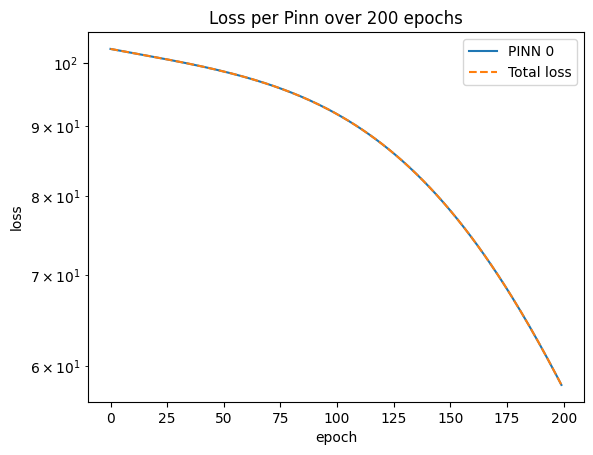

In [13]:
import matplotlib.pyplot as plt

a_losses = np.asarray(losses)
t_0 = 0
t = np.arange(t_0, n_iter)
print(a_losses.shape)
for i in range(2):
    print(a_losses[i,t_0])


for i in range(1):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [14]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)
min_, max_ = total_pred.min(), total_pred.max()

print(np.array(points).shape)
#true_value = onp.zeros_like(predictions[0])
#for i, point in enumerate(points[0]):
#    true_value[i]=np.sin(np.pi * point[0]) * np.sin(np.pi * point[1])

print(total_points.shape)
#u_vmap = vmap(u_star, (0))
#true_value = u_vmap(total_points).reshape(-1, 1)
#print(true_value.shape)

#for point, pred in zip(points, predictions):
#    plt.scatter(point[:, 0], point[:, 1], c=true_value, cmap="turbo")
    #plt.clim(min_, max_)

#plt.colorbar()

(1, 996004, 2)
(996004, 2)


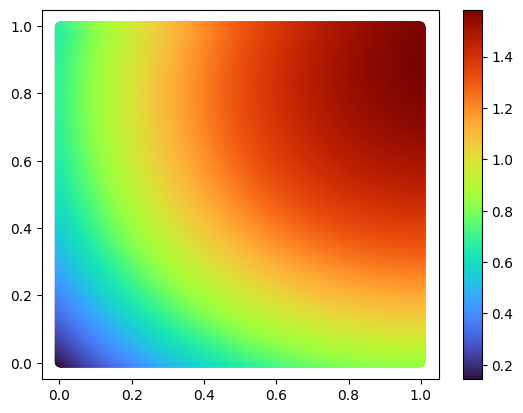

In [15]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [16]:
n = int(np.sqrt(total_points.shape[0]))
X = total_points[:, 0]
Y = total_points[:, 1]

X = X.reshape(n, n)
Y = Y.reshape(n, n)

total_pred=total_pred.reshape(n,n)
true_value= true_value.reshape(n,n)
inner = onp.trapz((total_pred-true_value)**2, total_points[0:n,0], axis=0)
outer = onp.trapz(inner, total_points[::n,1], axis=0)
l2_err = np.sqrt(outer)
normalizer = np.sqrt(onp.trapz(onp.trapz((true_value)**2, total_points[0:n,0], axis=0),total_points[::n,1], axis=0))
print(l2_err/normalizer)

NameError: name 'true_value' is not defined

In [ ]:
### Rel L2 norm errors
#0.0013423298
#0.0014273562 (new points)
#0.0012827385
print(normalizer)